# Traffic Event Distrubution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

In [2]:
records=pd.read_csv('random_sample_data_MQ.csv',iterator=True,chunksize=10**5,low_memory=False)

mylist=[]
for chunk in records:
    mylist.append(chunk[['Type','StartTime(UTC)','EndTime(UTC)','City','LocalTimeZone']])
    
records=pd.concat(mylist).apply(pd.to_datetime,errors='ignore').dropna().\
            rename(columns={'StartTime(UTC)':'Start','EndTime(UTC)':'End'})

In [3]:
records['LocalTimeZone'].unique()

array(['EST', 'PST', 'EDT', 'CST', 'CDT', 'MST', 'PDT', 'MDT'],
      dtype=object)

In [4]:
dic={'EDT':datetime.timedelta(hours=-4), 'EST':datetime.timedelta(hours=-5),
     'CDT':datetime.timedelta(hours=-5), 'CST':datetime.timedelta(hours=-6), 
     'MDT':datetime.timedelta(hours=-6), 'MST':datetime.timedelta(hours=-7),
     'PDT':datetime.timedelta(hours=-7), 'PST':datetime.timedelta(hours=-8)}

records['Start']=records['Start']+records['LocalTimeZone'].map(lambda x:dic[x])

In [5]:
records.shape

(1870421, 5)

## Hourly

We need to find the frequency of events during different hours of a day.(Considering that quite long time of the accidetents like construction, we only care about events start time.)

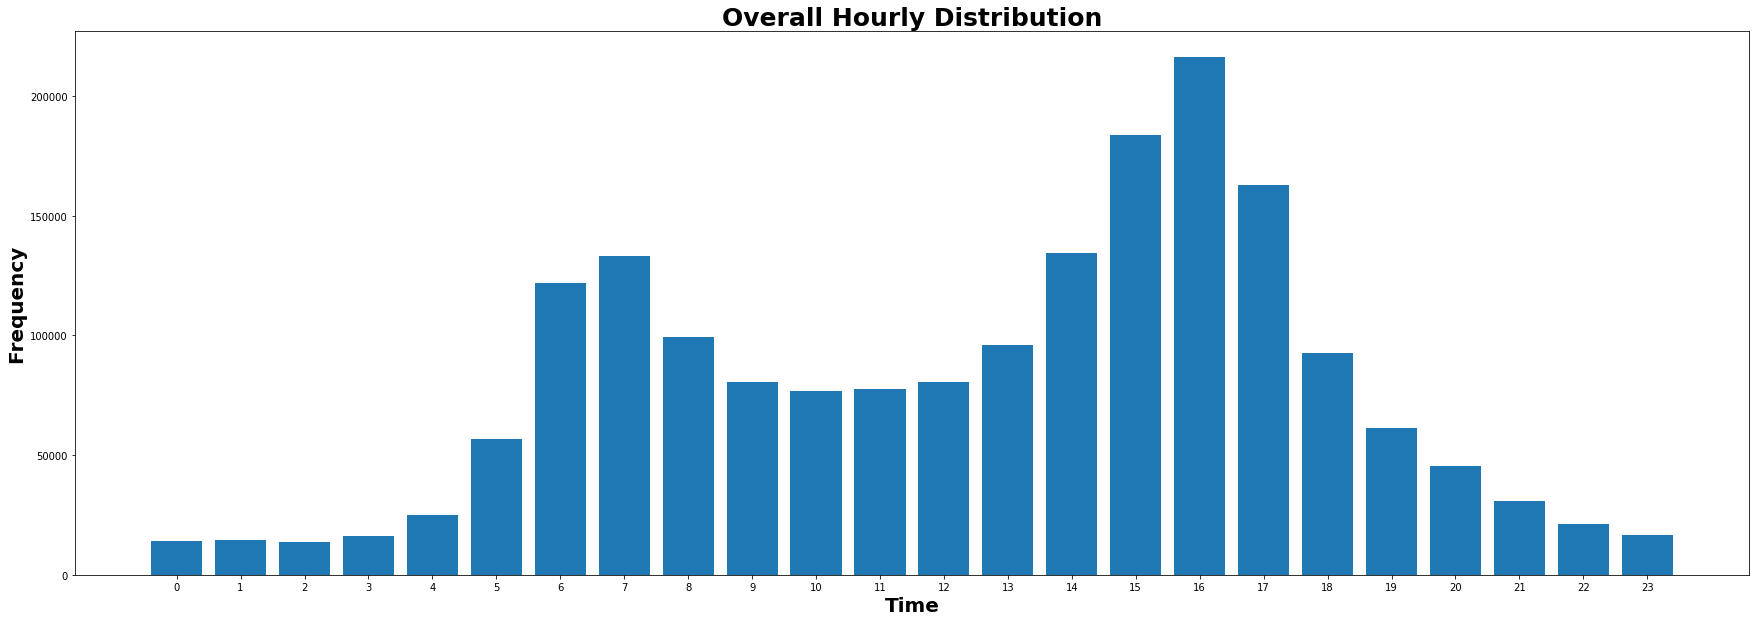

In [6]:
plt.figure(figsize=(30, 10))
plt.title('Overall Hourly Distribution',fontdict={'fontsize': 25, 'fontweight': 'bold'})
start_time = records['Start'].map(lambda x:x.hour).value_counts().sort_index().to_dict()
plt.bar(range(len(start_time.keys())), start_time.values())
plt.xlabel('Time',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.ylabel('Frequency',fontdict={'fontsize': 20, 'fontweight': 'bold'})
_ =plt.xticks(range(len(start_time.keys())), start_time.keys())

There are two peak for the overall events: 17:00 and 8:00.(Decreasing)

### Different types of events

In [7]:
def hourly_distribution(df,ax,title):
    start_time = df['Start'].map(lambda x:x.hour).value_counts().sort_index().to_dict()
    ax.bar(range(len(start_time.keys())), start_time.values(),tick_label=list(start_time.keys()))
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_xlabel('time')
    ax.set_ylabel('frequency')

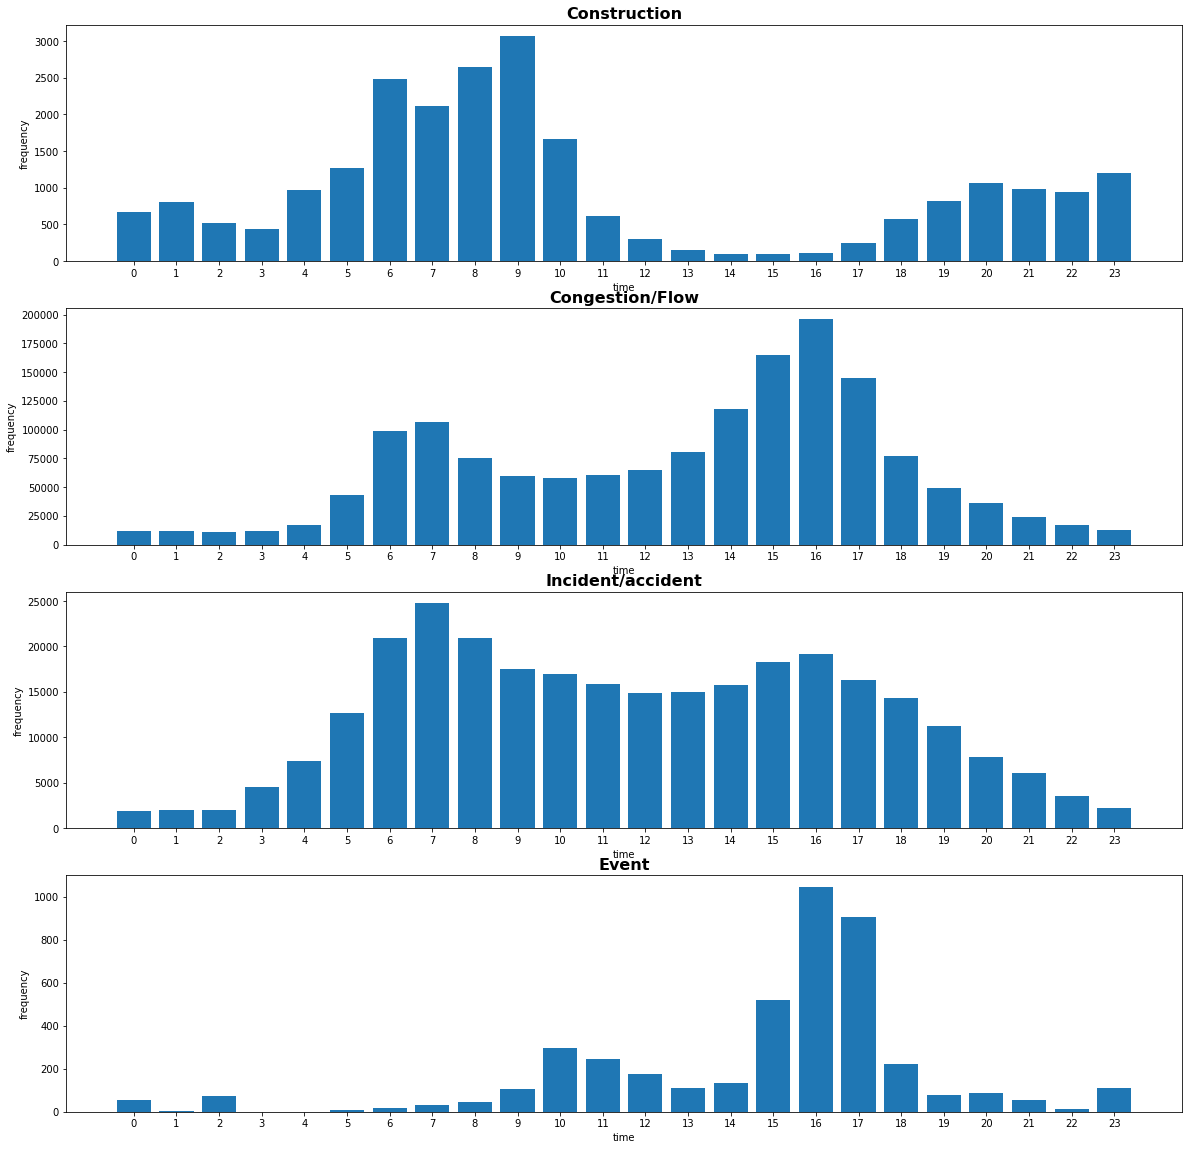

In [8]:
fg, axes = plt.subplots(4, 1, figsize=(20, 20))
kinds=records.Type.unique()

for i in range(len(kinds)):
    hourly_distribution(records[records['Type']==kinds[i]],axes[i],kinds[i])

The peaks for different events(decreasing):  
Congestion/Flow: 17：00; 8:00   
Incident/Accident: 8:00; 17:00    
Event: 27:00  
Construction: 10:00

### Major cities and other cities
To find the special points of the pattern for those major cities, we need to define major cities first.

In [9]:
cities=records['City'].value_counts()[:10].index
cities

Index(['Los Angeles', 'Houston', 'Miami', 'New York', 'Atlanta', 'Chicago',
       'Dallas', 'Austin', 'Brooklyn', 'Seattle'],
      dtype='object')

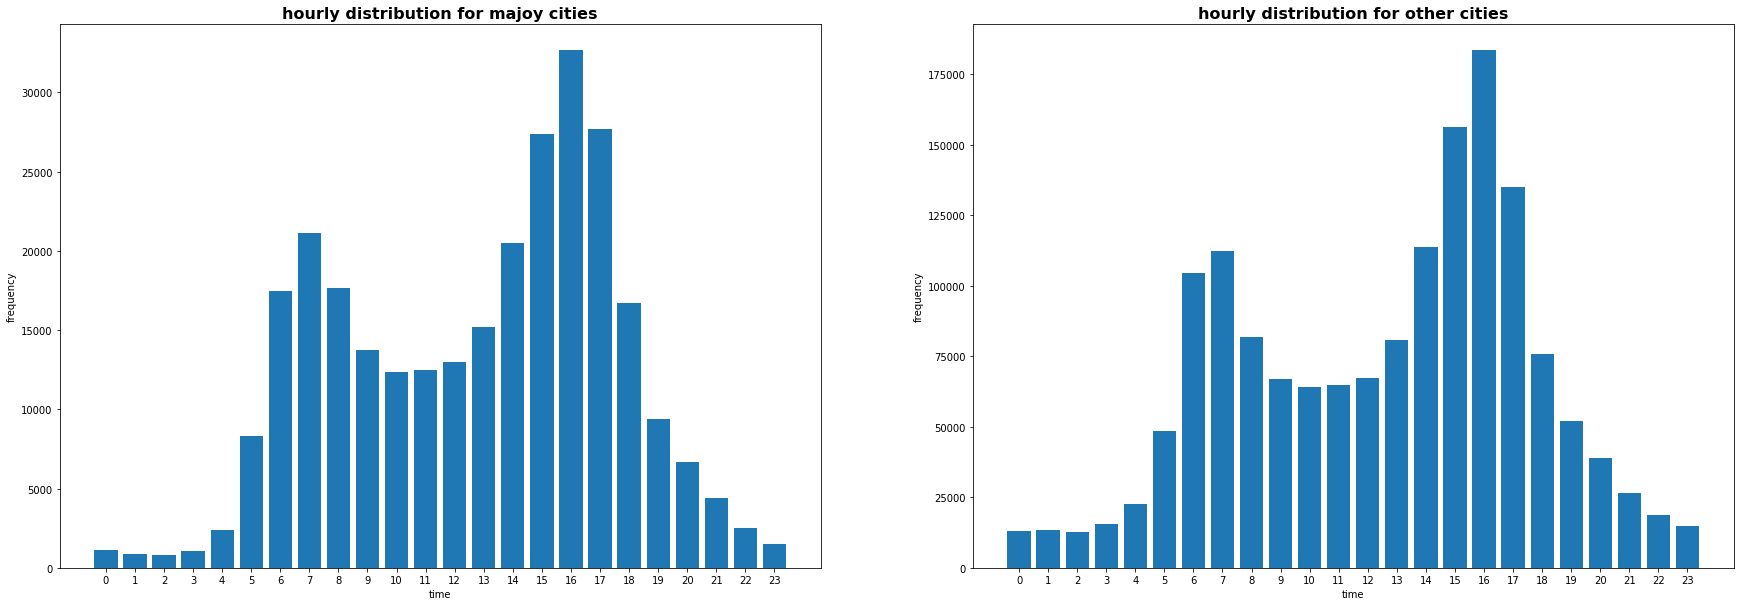

In [10]:
fg, axes = plt.subplots(1, 2, figsize=(30, 10))
major_cities=records.loc[records['City'].isin(cities)]
other_cities=records.loc[records['City'].isin(cities)==False]

hourly_distribution(major_cities,axes[0],'hourly distribution for majoy cities')
hourly_distribution(other_cities,axes[1],'hourly distribution for other cities')

The distribution of major cities and the distribution of other cities are quite similar. We could observe the distribution of different types.

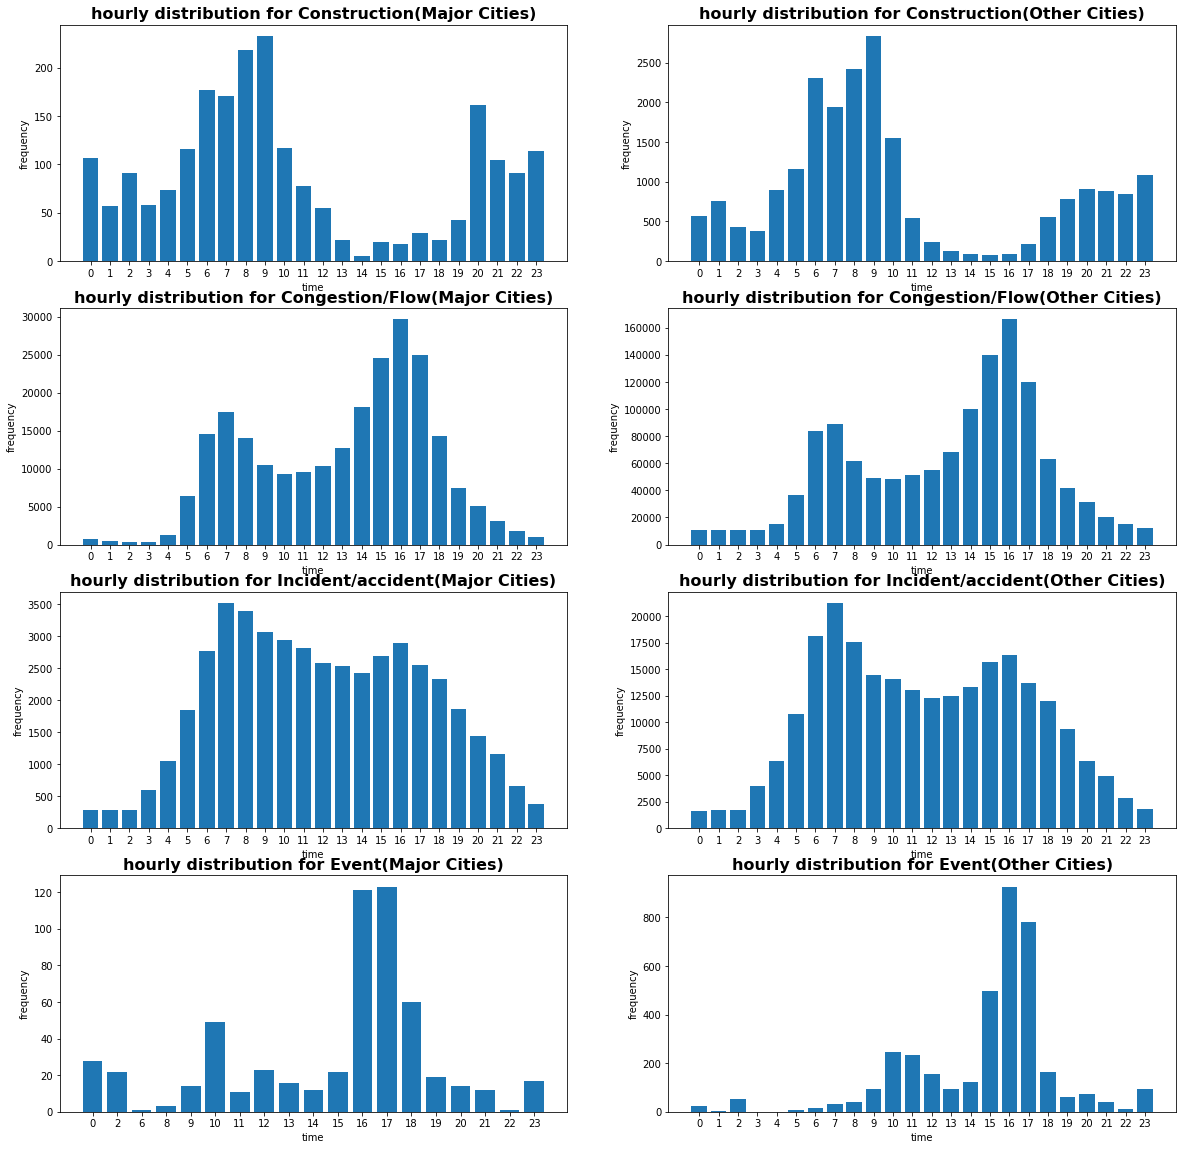

In [11]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    hourly_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],'hourly distribution for '+kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    hourly_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],'hourly distribution for '+kinds[i]+"(Other Cities)")

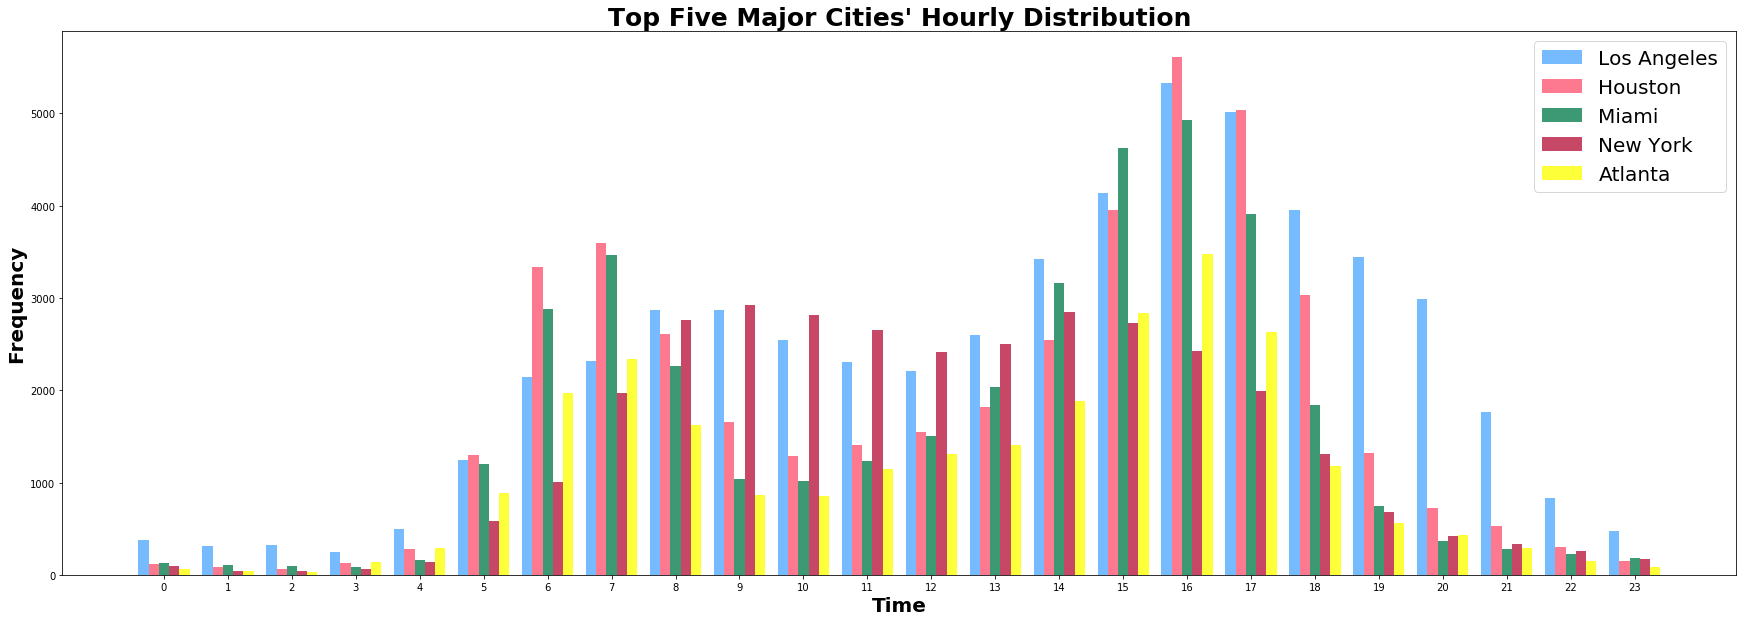

In [12]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(24))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records.loc[records['City']==city]
    start_time = target['Start'].map(lambda x:x.hour).value_counts().sort_index().to_dict()
    plt.bar(x, start_time.values(), width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(24)],range(24))
plt.legend(prop = {'size':20})
plt.title("Top Five Major Cities\' Hourly Distribution", fontdict={'fontsize': 25, 'fontweight': 'bold'})
plt.xlabel('Time',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.ylabel('Frequency',fontdict={'fontsize': 20, 'fontweight': 'bold'})
pass

Those top cities have similar patterns.

### Weekdays and weekends

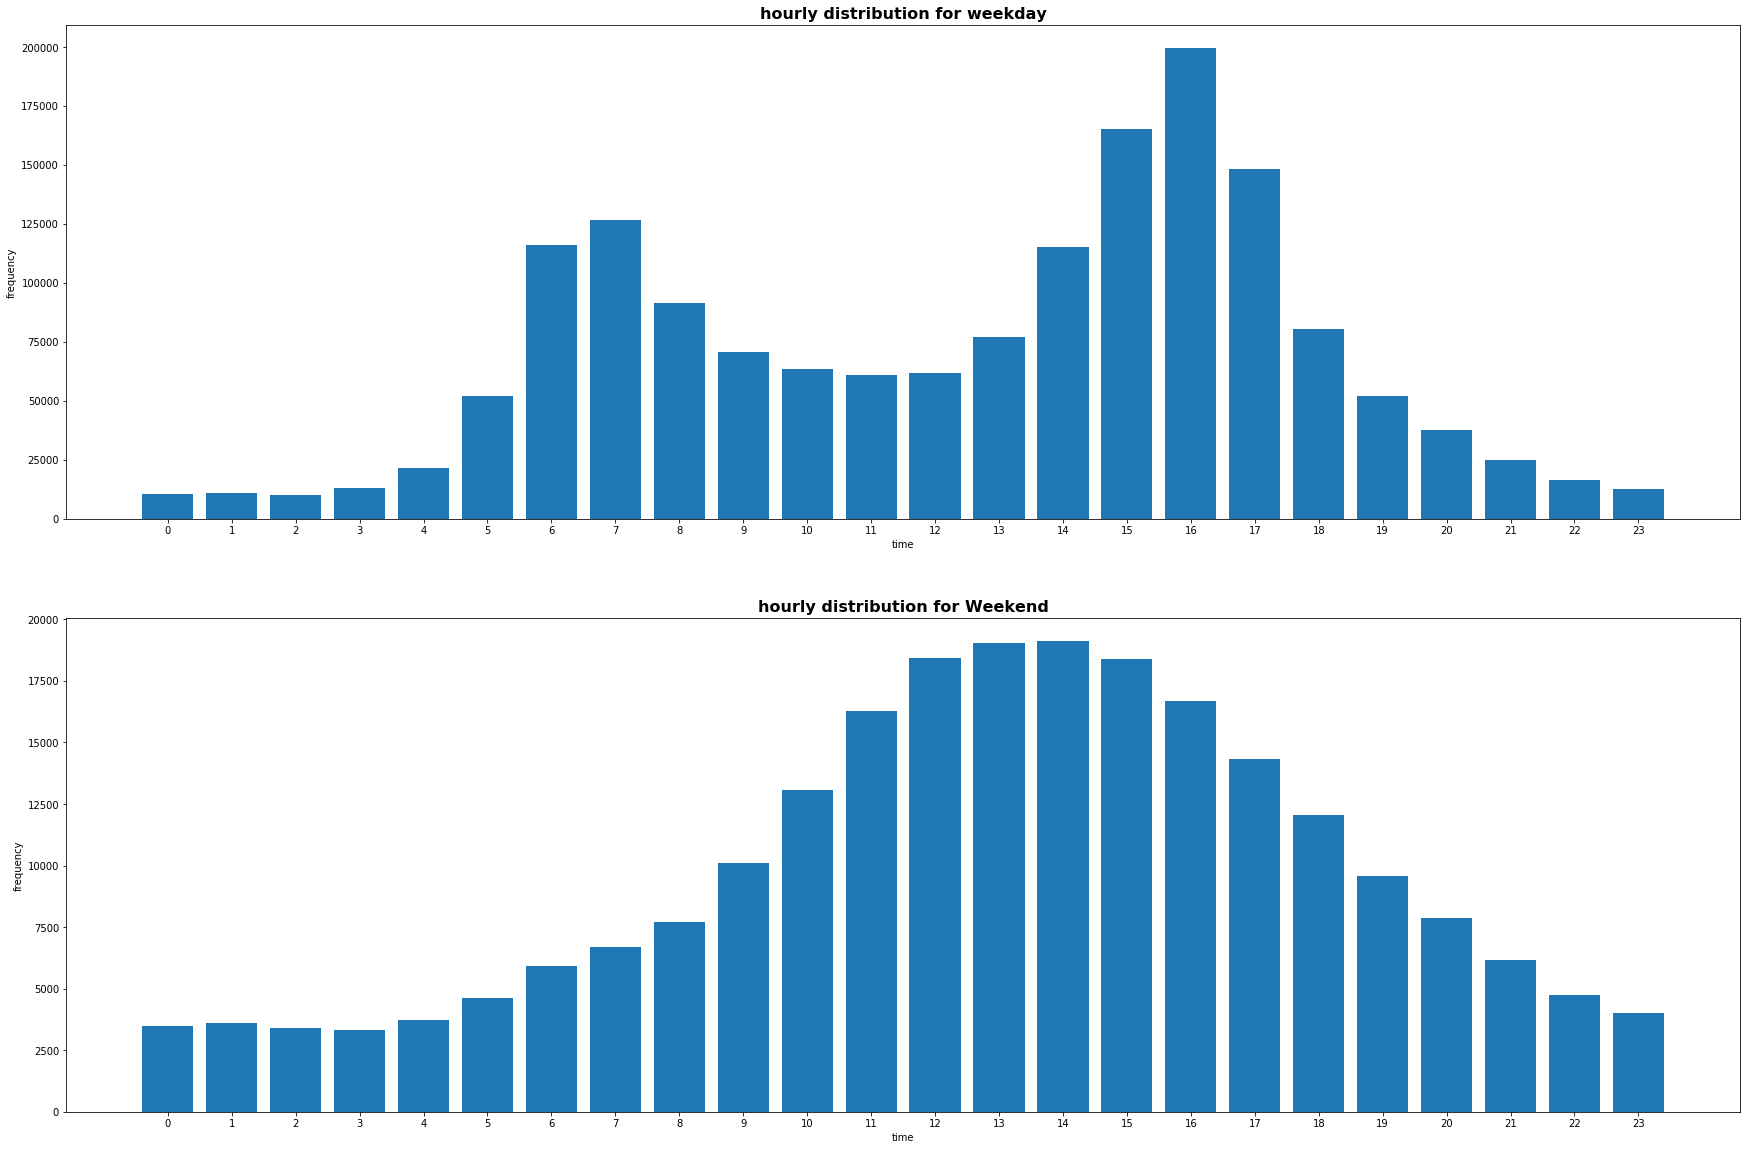

In [13]:
weekday_if=records['Start'].map(lambda x:x.weekday()) <5
weekday=records.loc[weekday_if]
weekend=records.loc[weekday_if==False]

fg, axes = plt.subplots(2, 1, figsize=(30, 20))
hourly_distribution(weekday,axes[0],'hourly distribution for weekday')
hourly_distribution(weekend,axes[1],'hourly distribution for Weekend')

The peaks for weekdays(decreasing): 21:00; 12：00  
The peaks for weekends(decreasing): 0:00; 19:00

For various types:

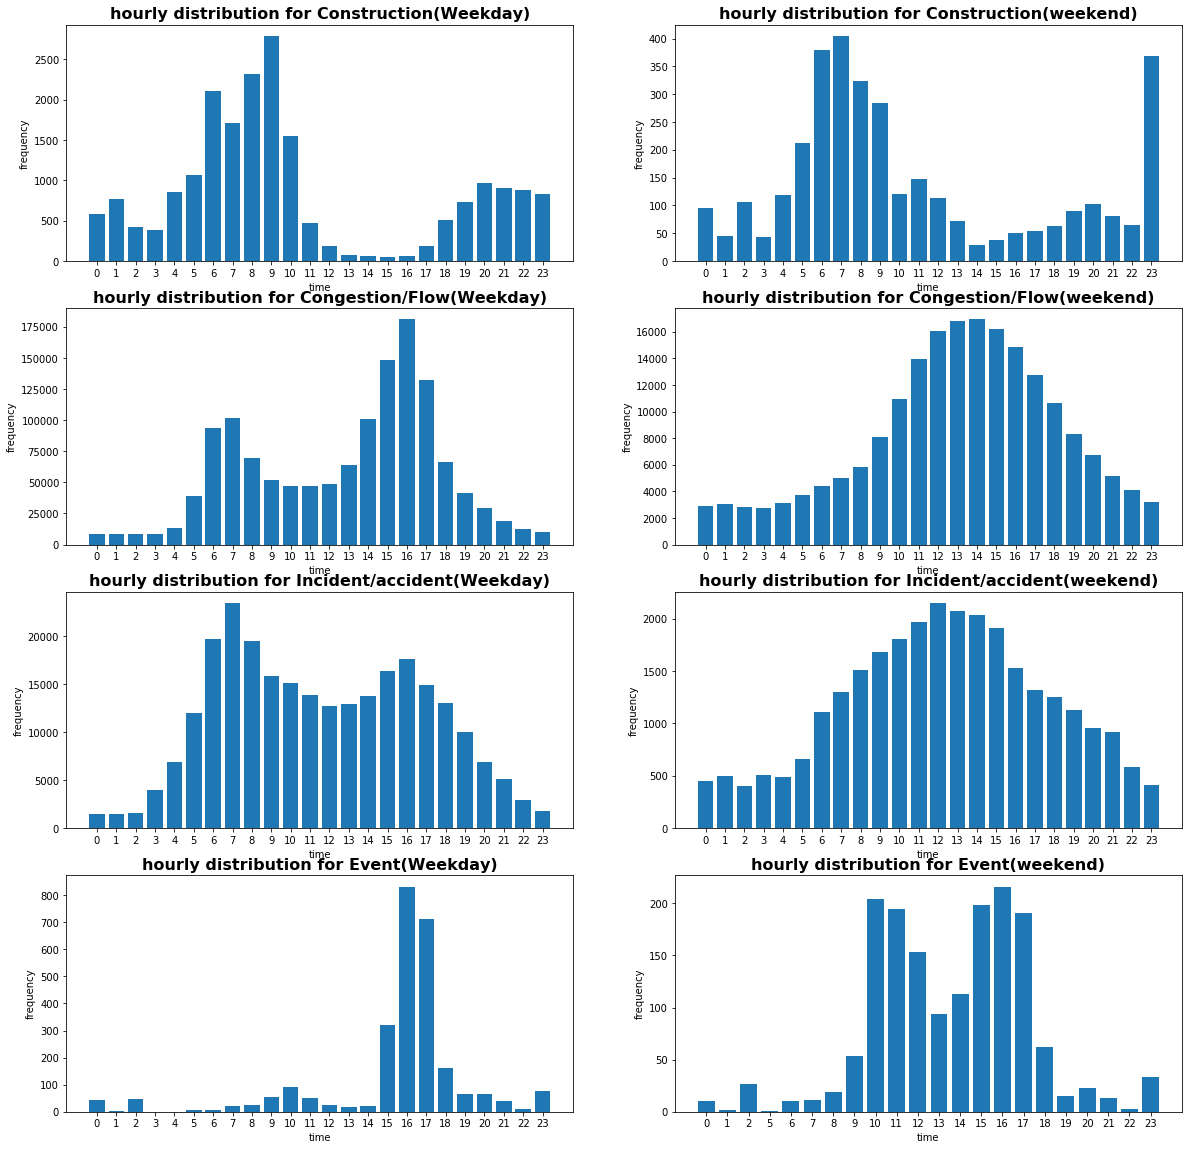

In [14]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    hourly_distribution(weekday[weekday['Type']==kinds[i]],axes[i][0],'hourly distribution for '+kinds[i]+"(Weekday)")
for i in range(len(kinds)):
    hourly_distribution(weekend[weekend['Type']==kinds[i]],axes[i][1],'hourly distribution for '+kinds[i]+"(weekend)")

Apprently, the major difference between peaks is mainly caused by incidents/accidents and congestions. The two types of events both meets the pattern.

On the other hand, events in weekend happens frequently in 11:00-18:00 comparing to that in weekdays.

## Daily

We need to find the frequency of events during different days of a week.(Considering the quite long time of the accidetents like construction, we only care about events start time.)

In [15]:
def daily_distribution(df,ax,title):
    start_time = df['Start'].map(lambda x:x.weekday()).value_counts().sort_index().to_dict()
    ax.bar(range(len(start_time.keys())), start_time.values(),tick_label=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_xlabel('time')
    ax.set_ylabel('frequency')

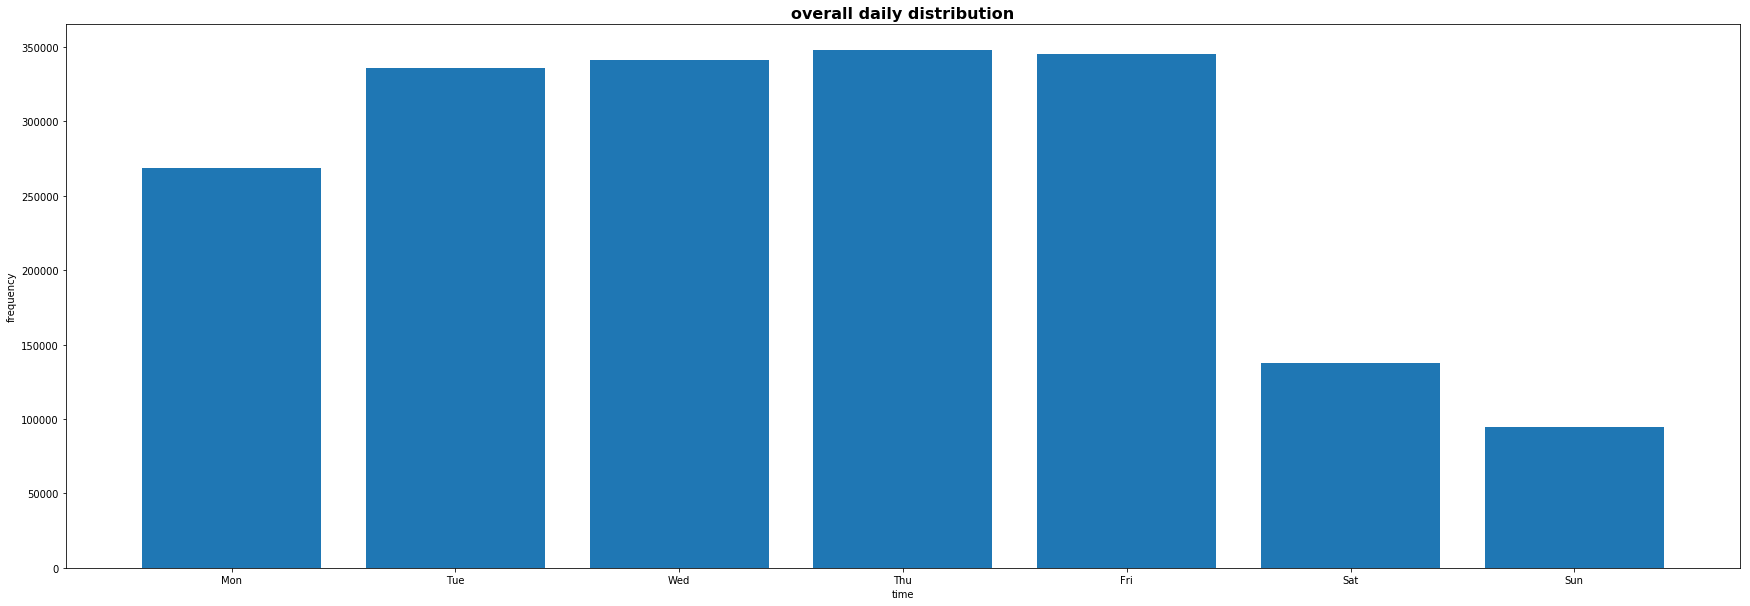

In [16]:
fg, axes = plt.subplots(1, 1, figsize=(30, 10))
daily_distribution(records,axes,'overall daily distribution')

Order of days' frequency:

In [17]:
records['Start'].map(lambda x:x.isoweekday()).value_counts().rename()

4    347827
5    345444
3    340837
2    335471
1    268531
6    137681
7     94630
dtype: int64

There are two apprent patern:  
1. events happen more frequently in weekday than in weekend.  
2. the frequency of events is decreasing in weekday.

### Different types of events

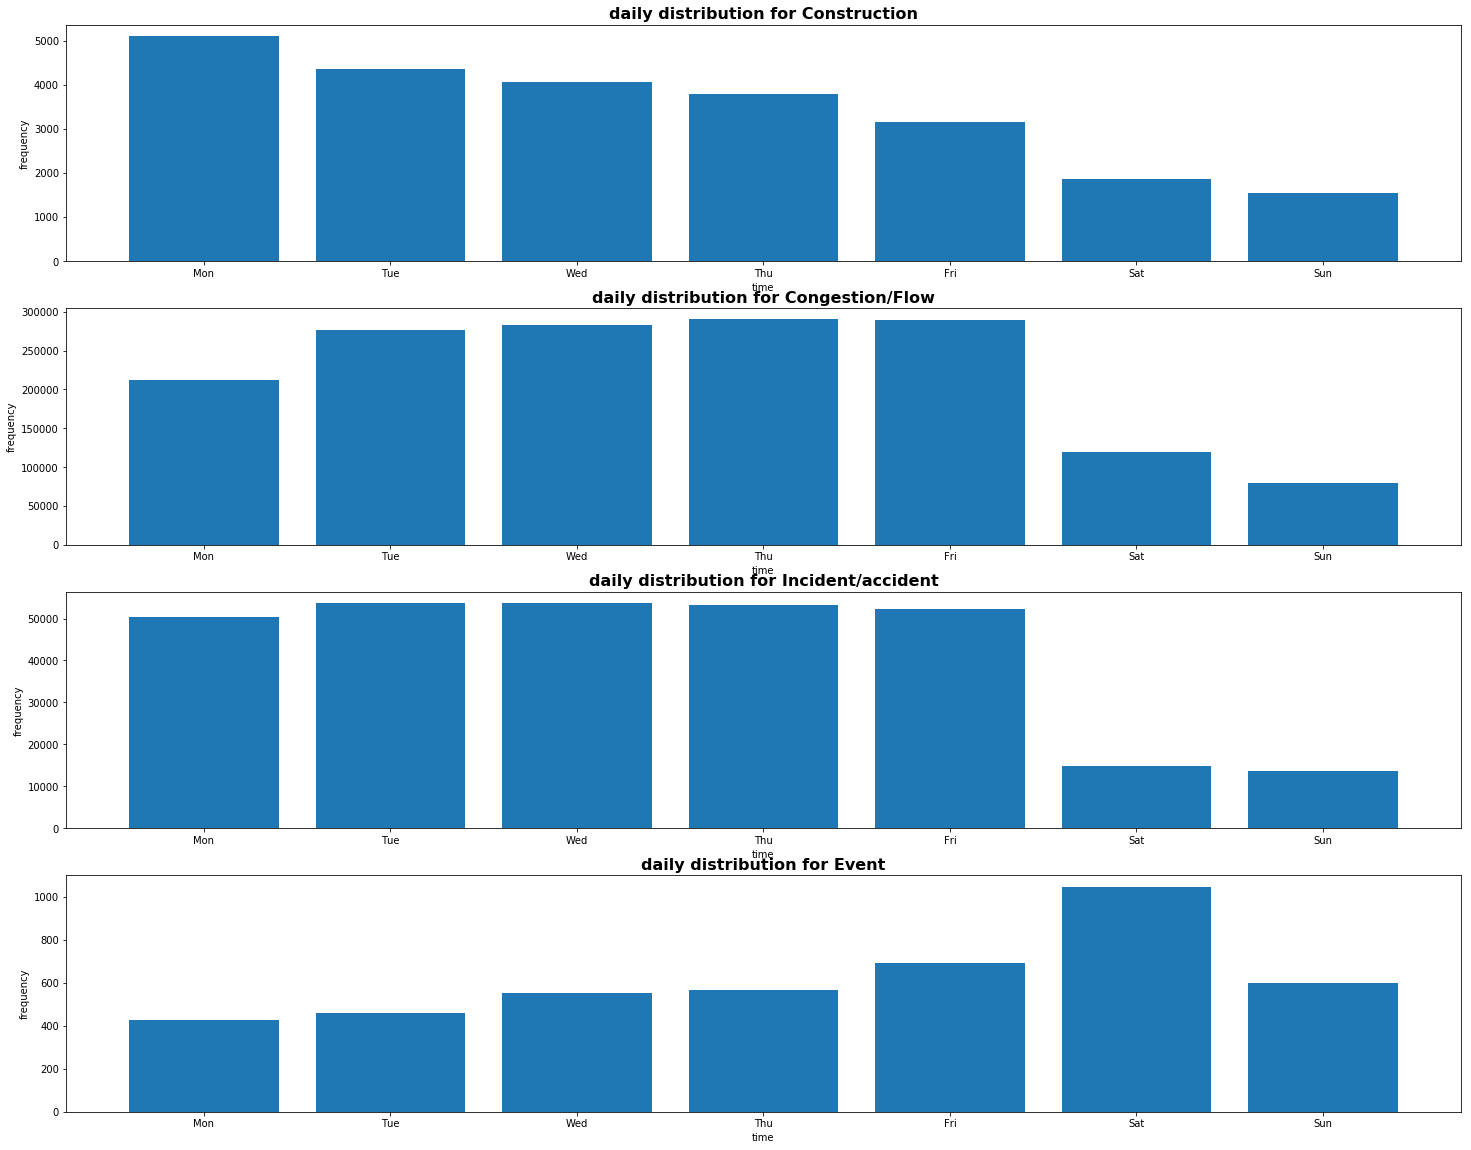

In [18]:
fg, axes = plt.subplots(4, 1, figsize=(25, 20))

for i in range(len(kinds)):
    daily_distribution(records[records['Type']==kinds[i]],axes[i],'daily distribution for '+kinds[i])

The congestion/flow and incident/accident both meet the two patterns for overall data, while for events accidents happen more frequently in weekend and for construction the decline trend do not exist.

### Major cities and other cities

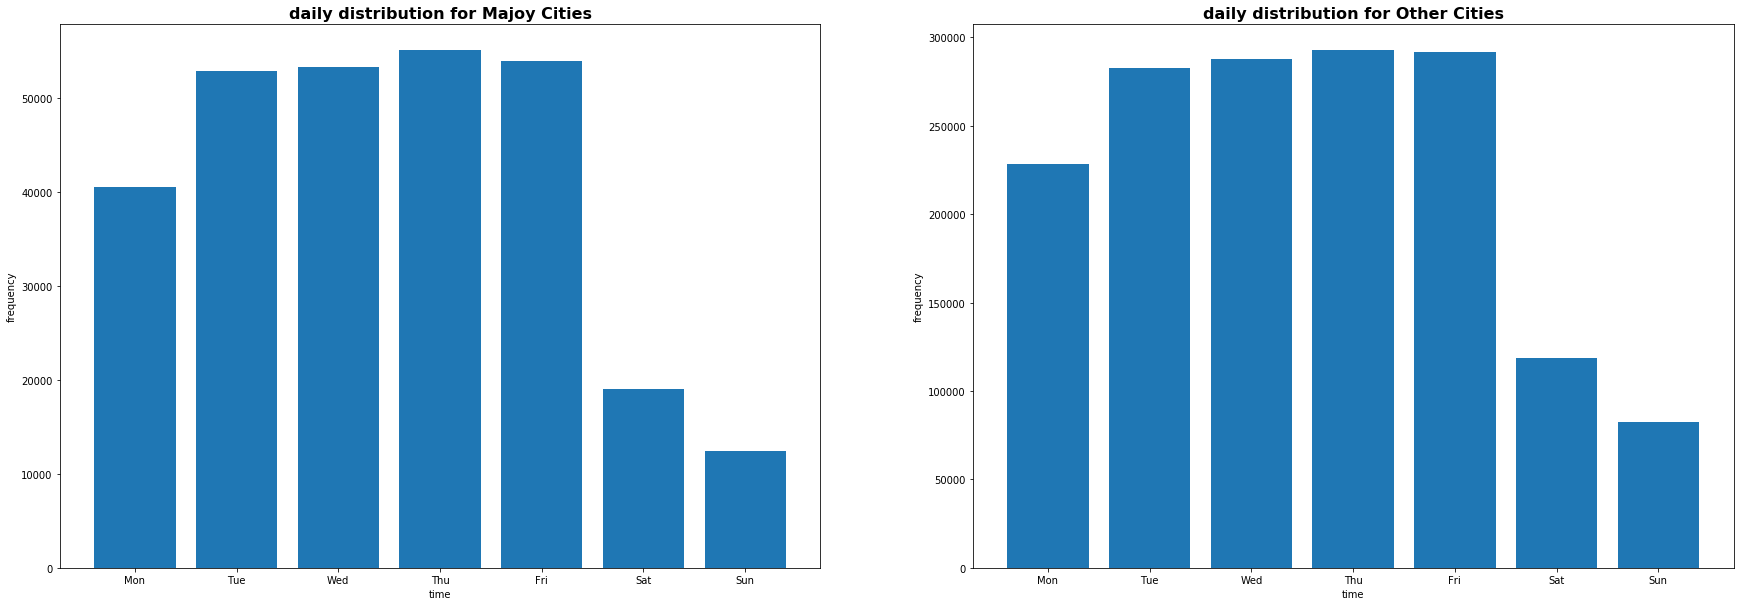

In [19]:
fg, axes = plt.subplots(1, 2, figsize=(30, 10))

daily_distribution(major_cities,axes[0],'daily distribution for Majoy Cities')
daily_distribution(other_cities,axes[1],'daily distribution for Other Cities')

It seems like no apprent differences exist.

Compare the distribution of different type:

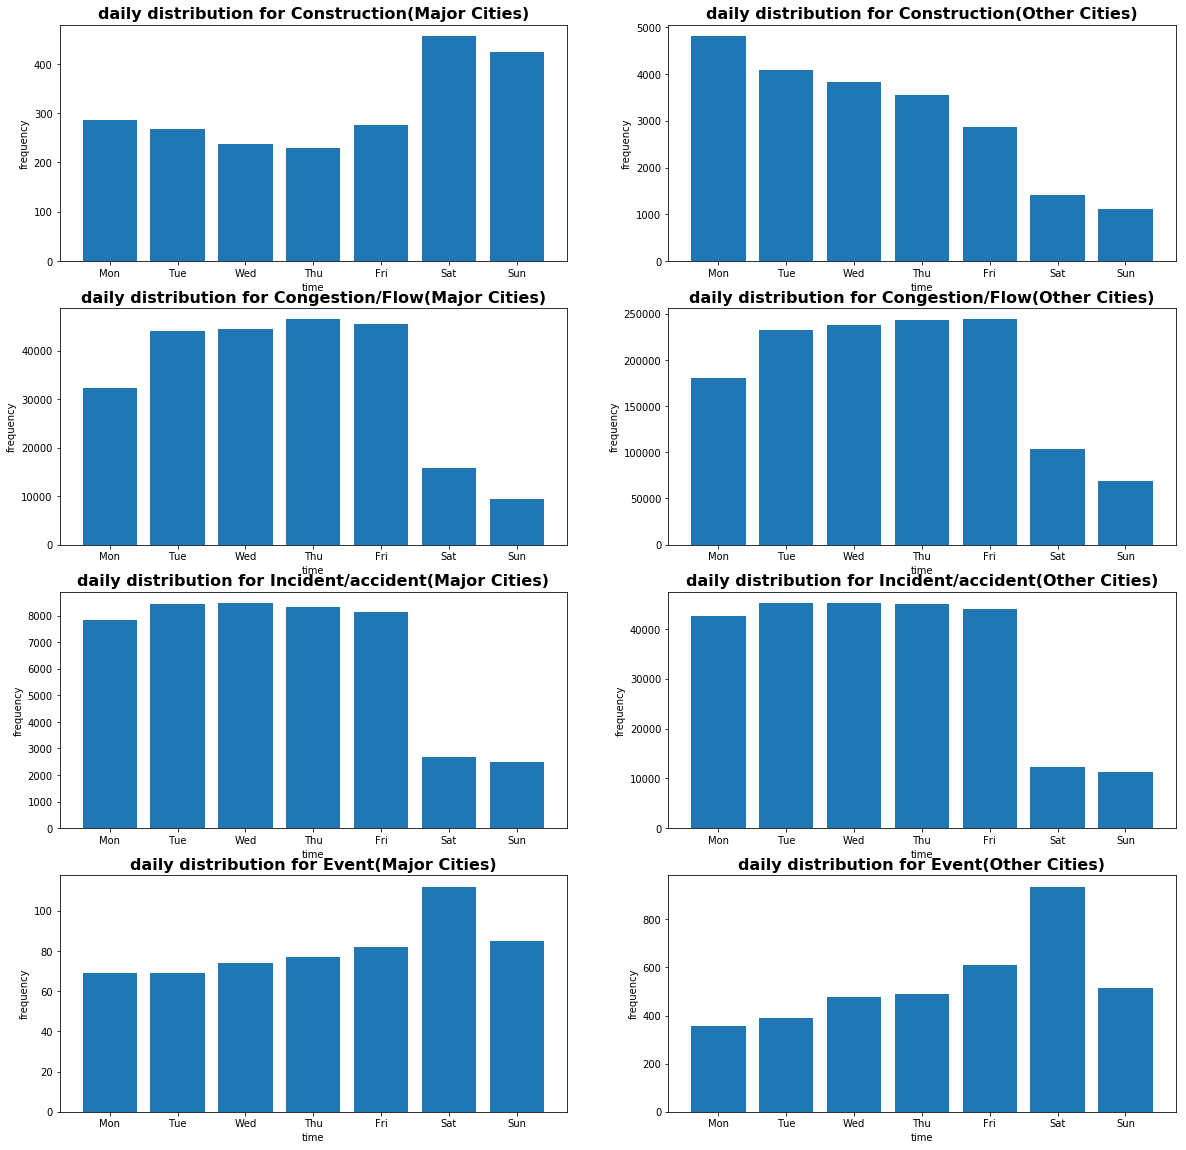

In [20]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    daily_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],'daily distribution for '+kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    daily_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],'daily distribution for '+kinds[i]+"(Other Cities)")

There is only one item we should pay attention to:
The feature of construction in major cities is totally different from that in other cities. Apprently, construction is major cities happens more frequently in weekend than in weekday, while for other cities the order is in contrast.

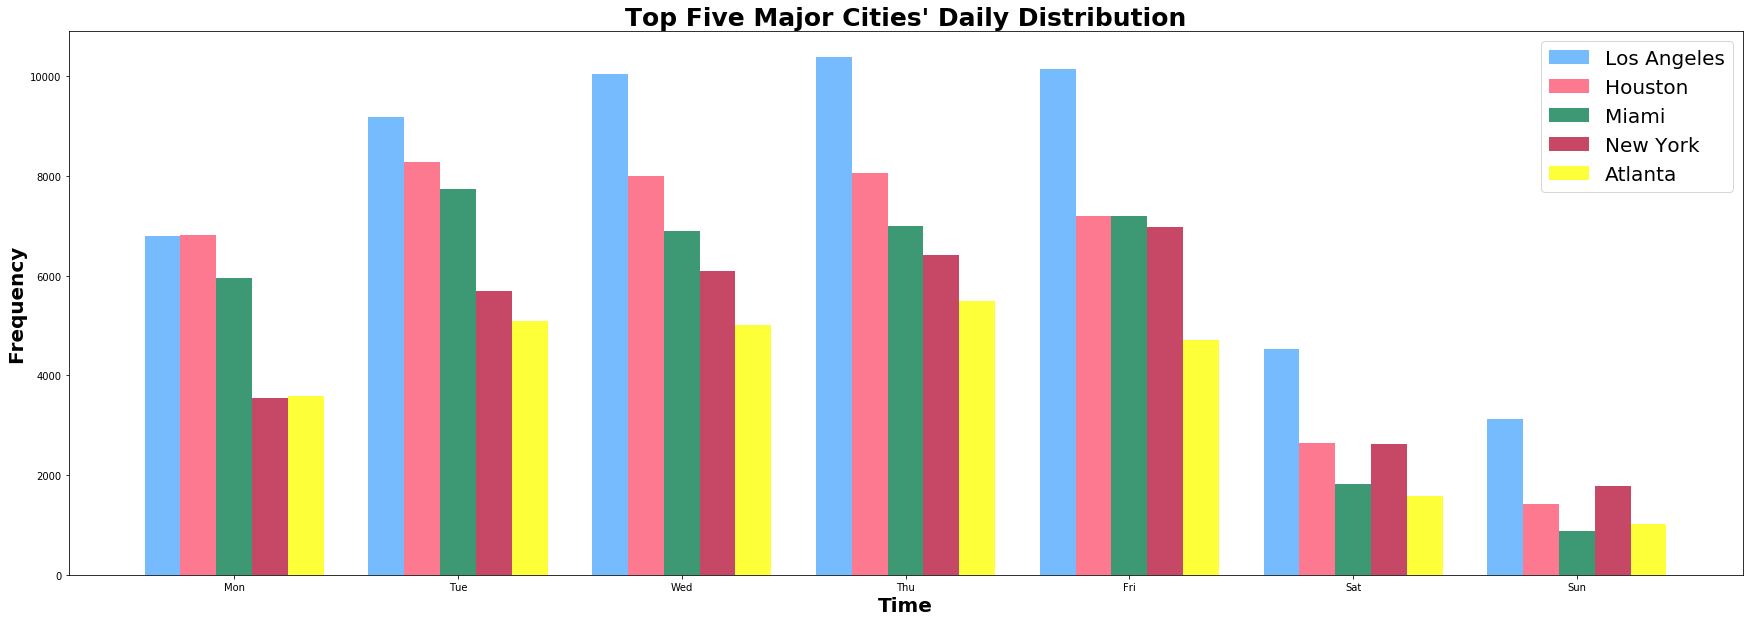

In [21]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(7))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records.loc[records['City']==city]
    start_time = target['Start'].map(lambda x:x.weekday()).value_counts().sort_index().to_dict()
    plt.bar(x, start_time.values(), width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(7)],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.legend(prop = {'size':20})
plt.title('Top Five Major Cities\' Daily Distribution', fontdict={'fontsize': 25, 'fontweight': 'bold'})
plt.xlabel('Time',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.ylabel('Frequency',fontdict={'fontsize': 20, 'fontweight': 'bold'})
pass

Those top cities have similar pattern.

## monthly

### Data Preprocessing

Considering we need to analyze monthly pattern. We need to observe distributions of time for different types first.

In [22]:
min(records['Start'])
ts=pd.Series([0]*len(records),index=records['Start'])
# records=records[re?cords.apply(lambda x: x['Start']<MIN[x['Type']],axis=1)]

In [23]:
ts.resample('M').count()

Start
2012-04-30         1
2012-05-31         0
2012-06-30         0
2012-07-31         0
2012-08-31         0
2012-09-30         0
2012-10-31         0
2012-11-30         0
2012-12-31         0
2013-01-31         1
2013-02-28         0
2013-03-31         1
2013-04-30         0
2013-05-31         0
2013-06-30         0
2013-07-31         0
2013-08-31         0
2013-09-30         0
2013-10-31         1
2013-11-30         0
2013-12-31         1
2014-01-31         0
2014-02-28         0
2014-03-31         0
2014-04-30         1
2014-05-31         0
2014-06-30         0
2014-07-31         1
2014-08-31         4
2014-09-30         1
               ...  
2015-12-31         9
2016-01-31        28
2016-02-29      1148
2016-03-31      3242
2016-04-30     11206
2016-05-31     13219
2016-06-30     27855
2016-07-31     32212
2016-08-31     55490
2016-09-30     58513
2016-10-31     51606
2016-11-30     58367
2016-12-31     58040
2017-01-31     51751
2017-02-28     52017
2017-03-31     62737
2017-04

Thus, we only need to take the data from Feburary 2016 to January 2018.

In [24]:
end=datetime.datetime(2018,2,1)
start=datetime.datetime(2016,2,1)
records=records[(records['Start']>=start)&(records['Start']<end)]

We need to find the frequency of events during different days of a week.(Considering the quite long time of the accidetents like construction, we only care about events start time.)

In [25]:
def monthly_distribution(df,ax,title):
    start_time = df['Start'].map(lambda x:x.month).value_counts().sort_index().to_dict()
    ax.bar(range(len(start_time.keys())), start_time.values(),tick_label=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})
    ax.set_xlabel('time')
    ax.set_ylabel('frequency')

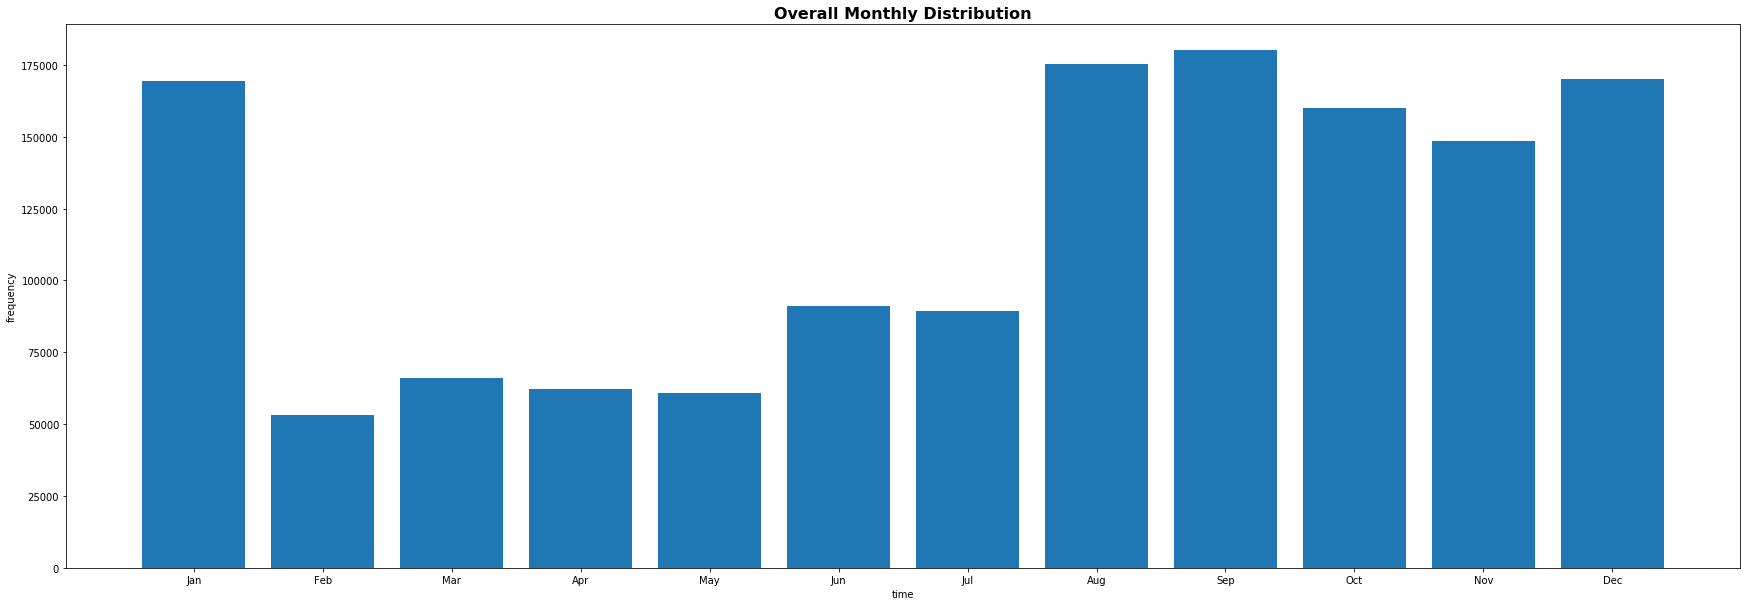

In [26]:
fg, axes = plt.subplots(1, 1, figsize=(30, 10))
monthly_distribution(records,axes,'Overall Monthly Distribution')

From Augest to January(next year), events happen more frequently.

### Different types of events

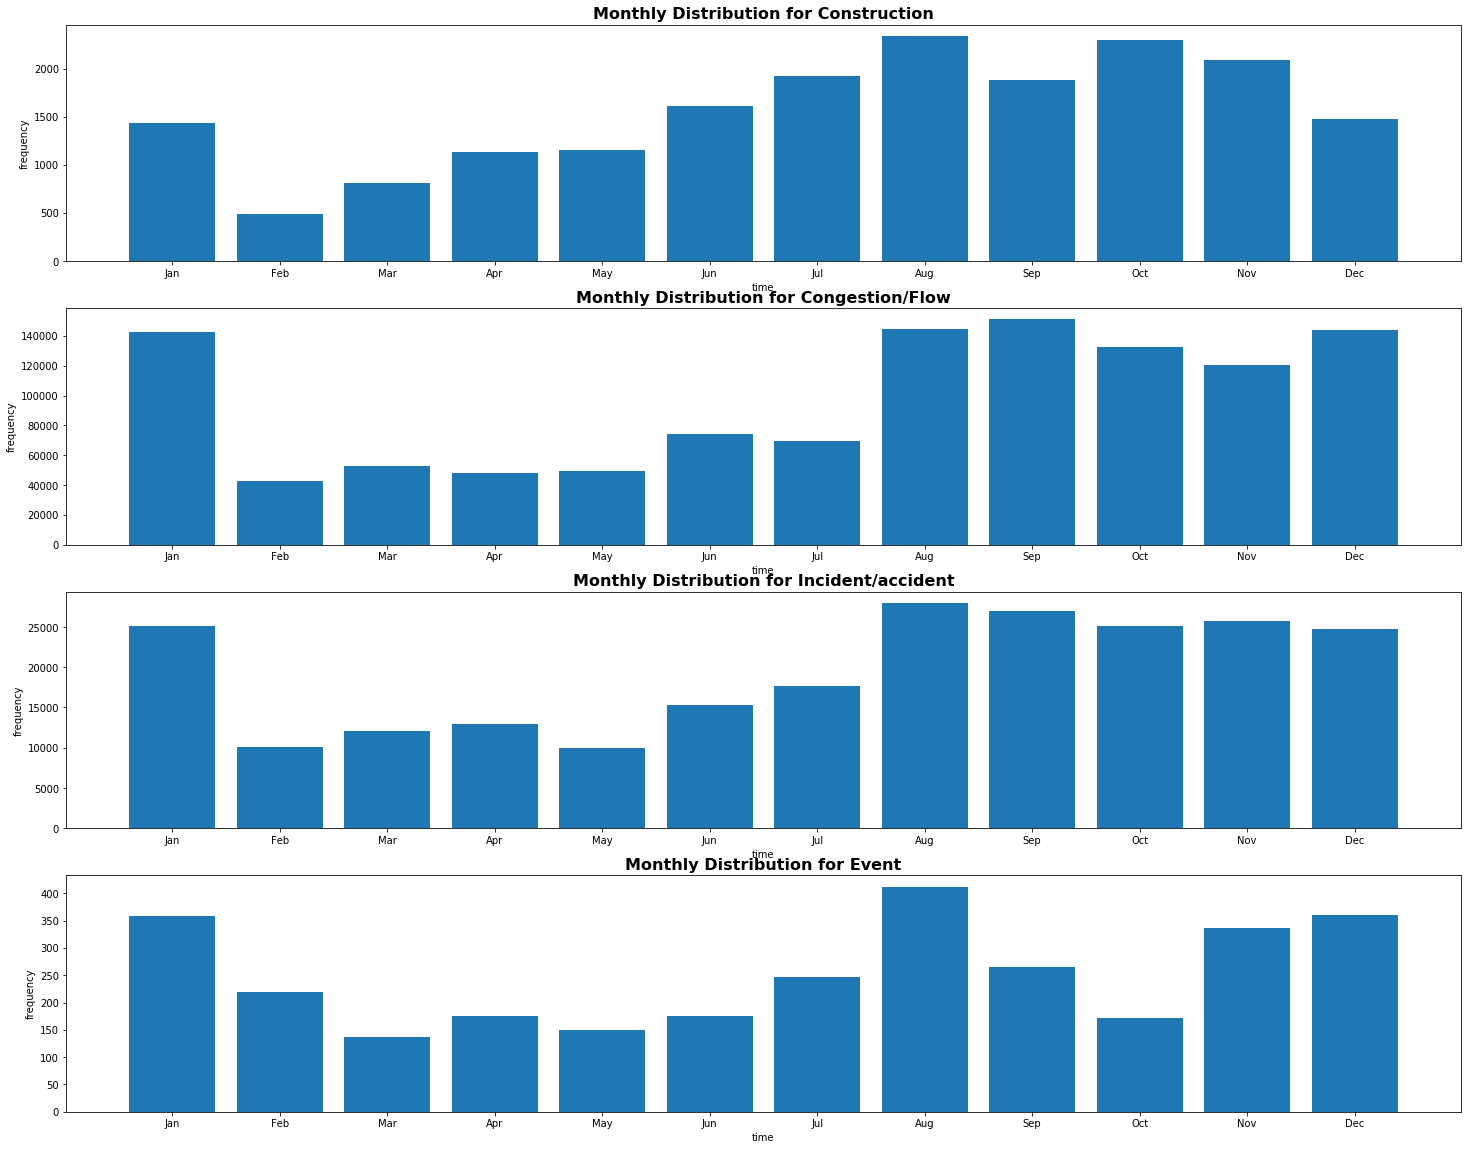

In [27]:
fg, axes = plt.subplots(4, 1, figsize=(25, 20))

for i in range(len(kinds)):
    monthly_distribution(records[records['Type']==kinds[i]],axes[i],'Monthly Distribution for '+kinds[i])

Apprently, the overall distribution's features is caused by congestion/Flow: From Augest to January, congestion/Flow happens more frequently.

Construction: happens sparsely in December, January Feburary.  
Incidents: No apprent features.  
Events: happens more frequently in Feburary.

## Major cities and other cities

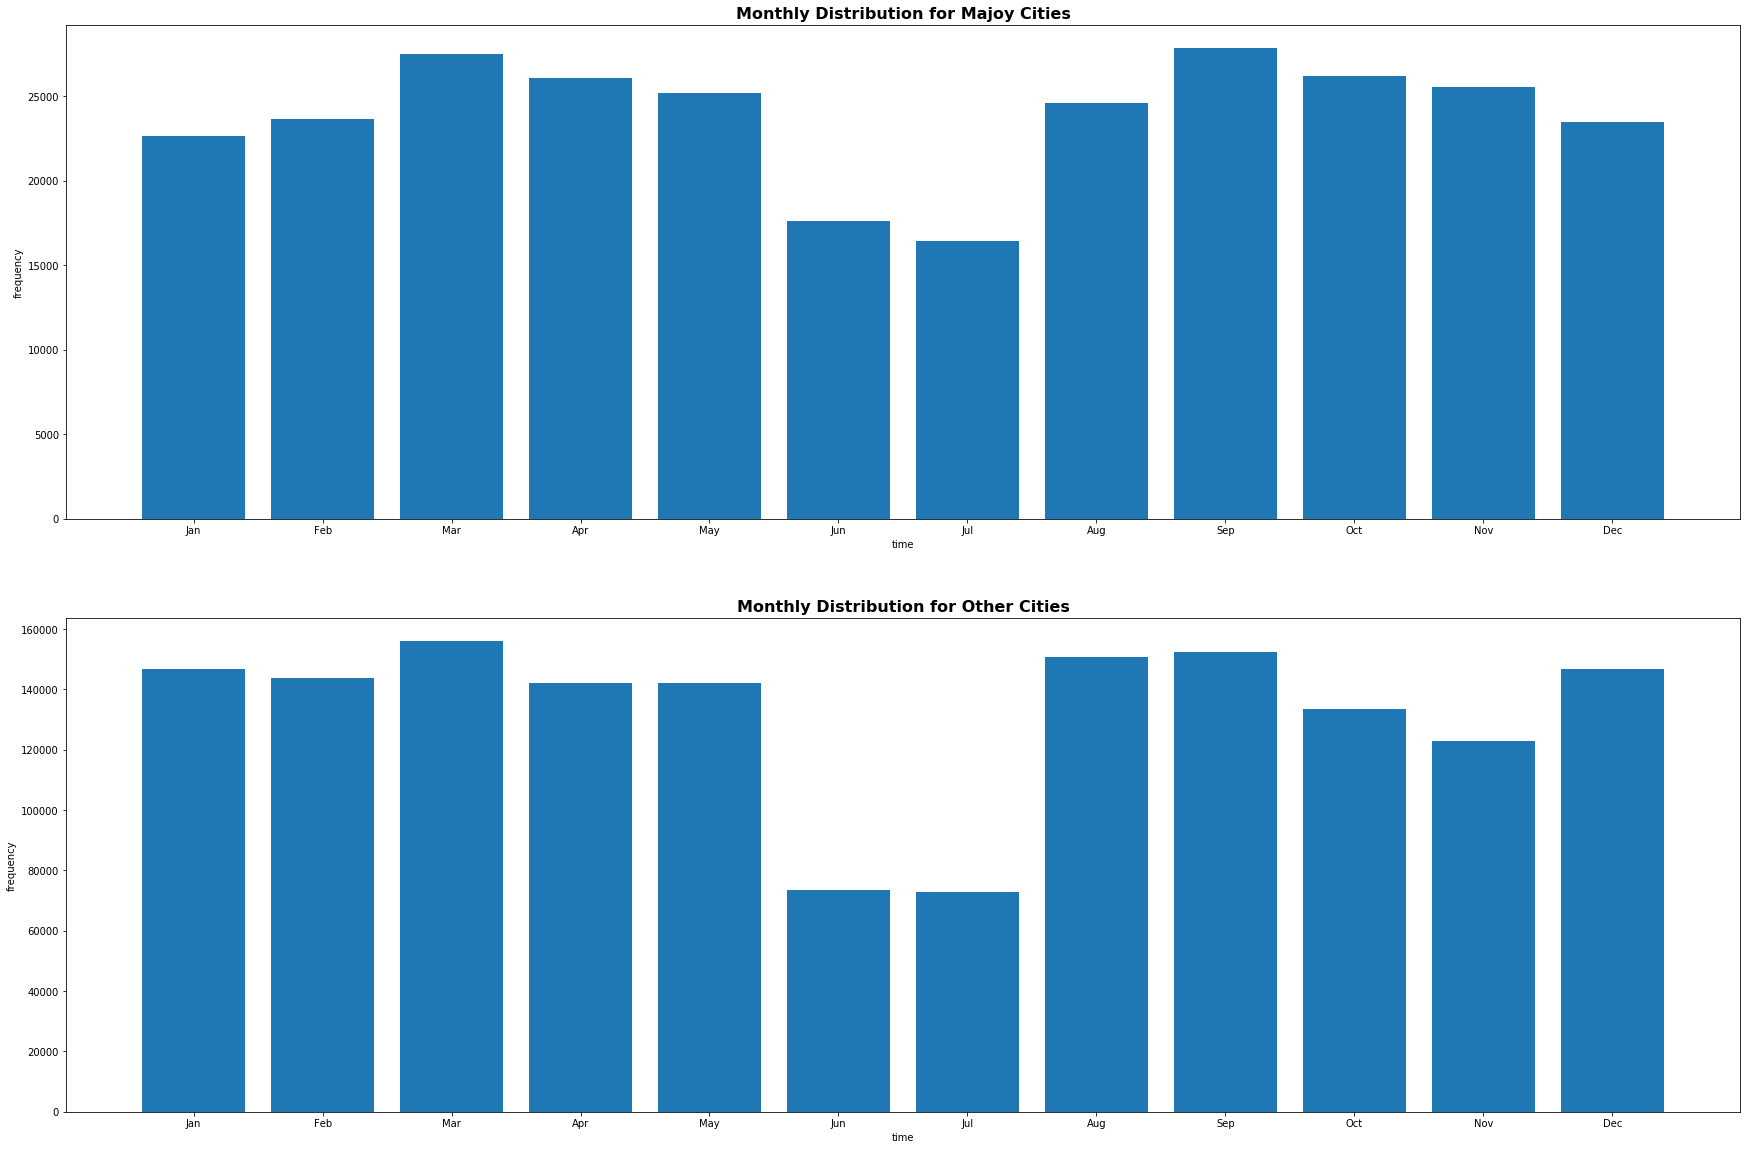

In [28]:
fg, axes = plt.subplots(2, 1, figsize=(30, 20))

monthly_distribution(major_cities,axes[0],'Monthly Distribution for Majoy Cities')
monthly_distribution(other_cities,axes[1],'Monthly Distribution for Other Cities')

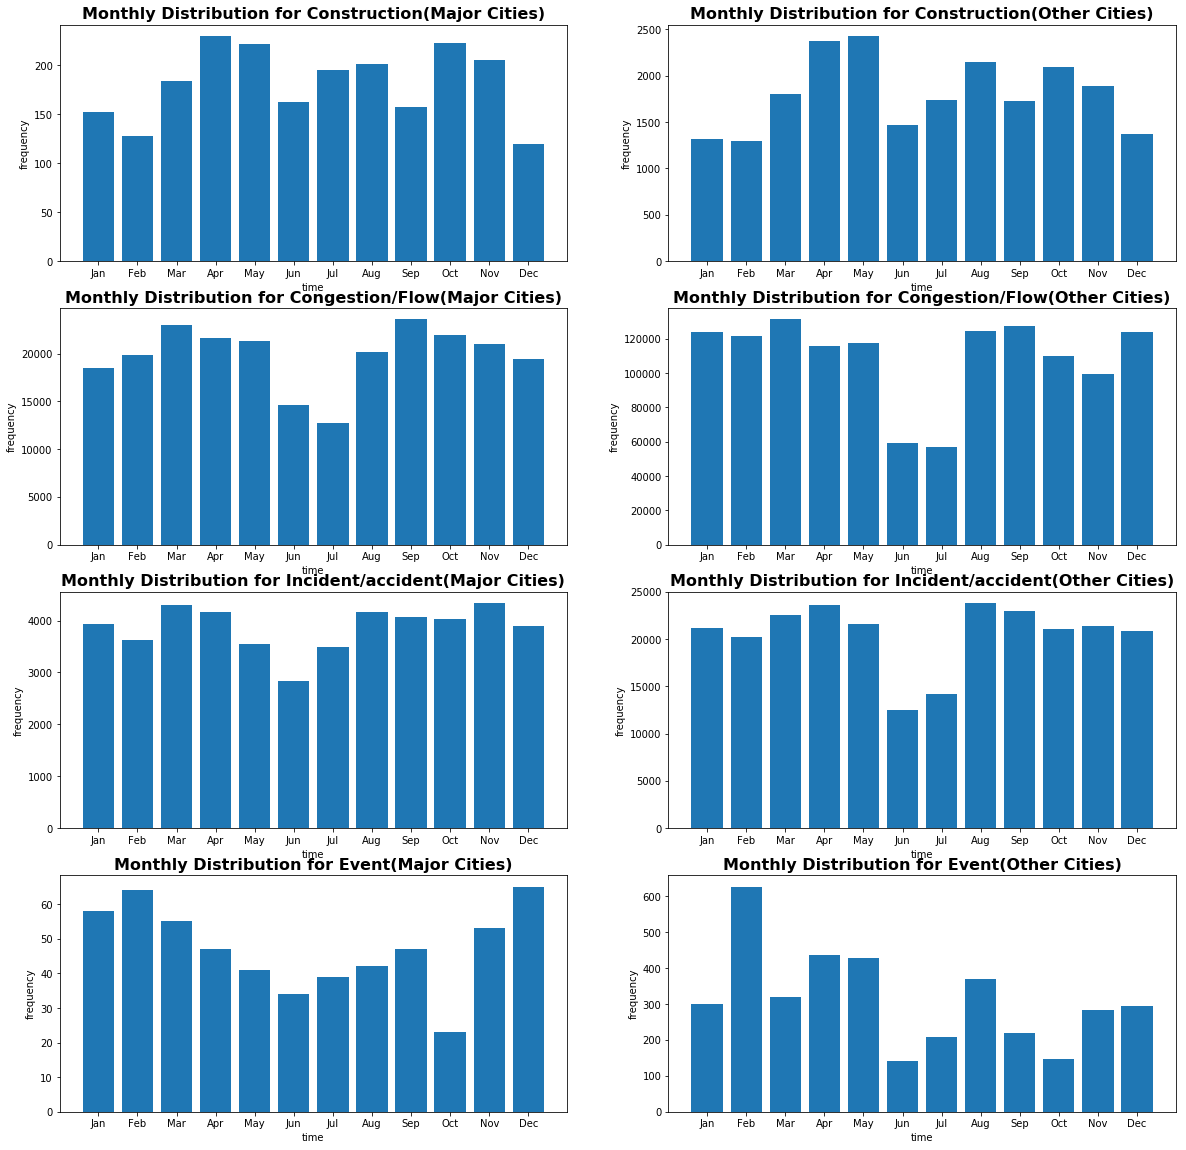

In [29]:
fg, axes = plt.subplots(4, 2, figsize=(20, 20))

for i in range(len(kinds)):
    monthly_distribution(major_cities[major_cities['Type']==kinds[i]],axes[i][0],'Monthly Distribution for '+kinds[i]+"(Major Cities)")
for i in range(len(kinds)):
    monthly_distribution(other_cities[other_cities['Type']==kinds[i]],axes[i][1],'Monthly Distribution for '+kinds[i]+"(Other Cities)")

In major cities and other cities, the patterns of construction, incident/accident and congestion/flow are similar.

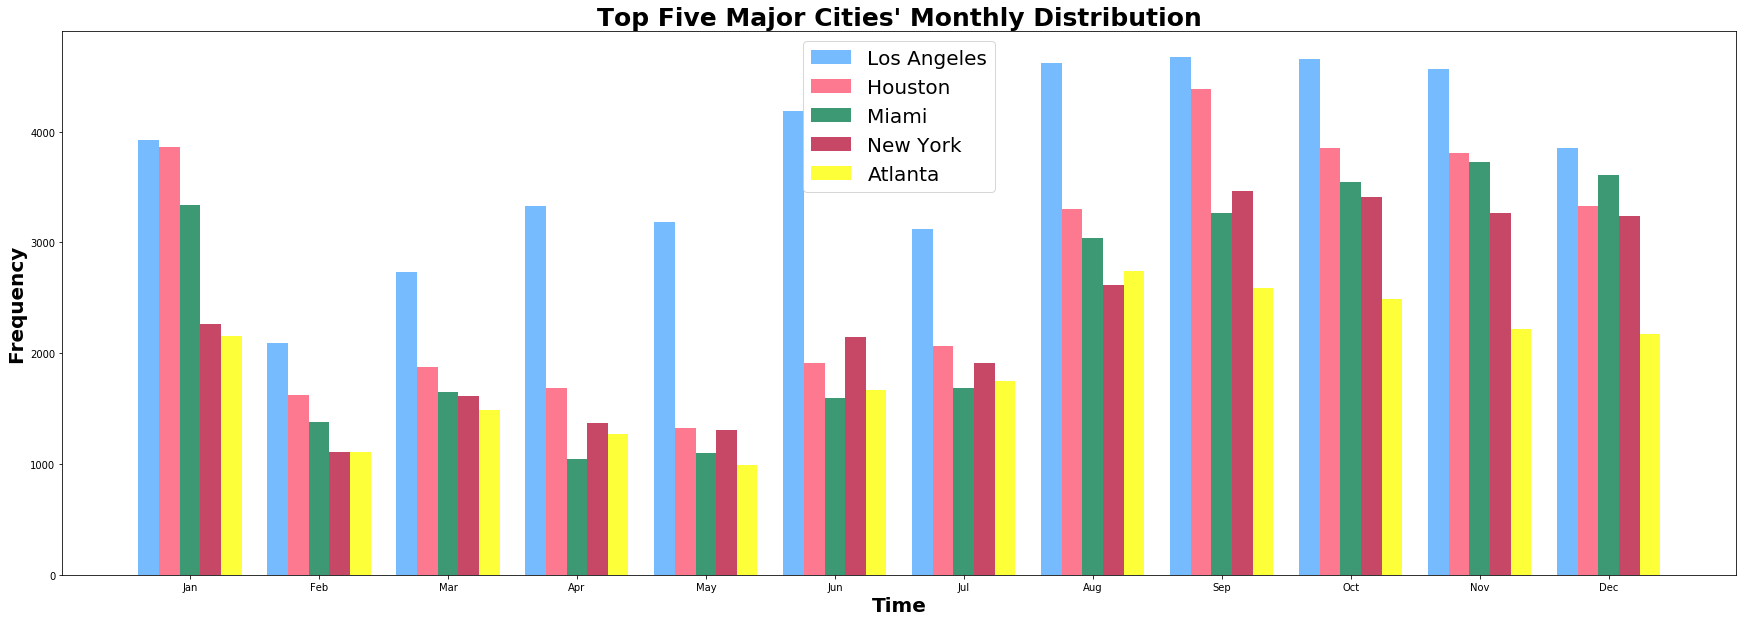

In [30]:
top_five=cities[:5]
plt.figure(figsize=(30,10))

x =list(range(12))  
total_width, n = 0.8, 5  
width = total_width / n  
cl=['lemon yellow','deep rose','ocean green','carnation','sky blue']
for city in top_five:
    target=records.loc[records['City']==city]
    start_time = target['Start'].map(lambda x:x.month).value_counts().sort_index().to_dict()
    plt.bar(x, start_time.values(), width=width, label=city,fc ='xkcd:'+cl.pop())
    for i in range(len(x)):
        x[i]+=width
plt.xticks([i+2*width for i in range(12)],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(prop = {'size':20})
plt.title('Top Five Major Cities\' Monthly Distribution', fontdict={'fontsize': 25, 'fontweight': 'bold'})
plt.xlabel('Time',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.ylabel('Frequency',fontdict={'fontsize': 20, 'fontweight': 'bold'})
pass

Those top cities have similar pattern.

## Appendix：

### Type distribution

In [31]:
def type_distribution(part, ax, title):
    groupby = part.groupby('Type')['Type'].count()
    labels= groupby.keys()
    values = groupby.values
    ax.axis('equal')
    ax.pie(values, labels=labels)
    ax.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'})

Overall:

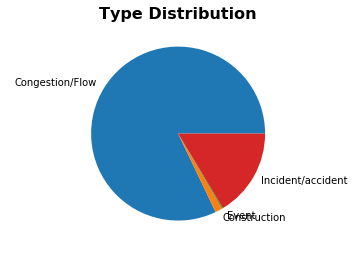

In [32]:
types = records.groupby('Type')['Type'].count()
plt.axis("equal")
plt.pie(types.values, labels=types.keys())
plt.title('Type Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()

Major cities and other cities:

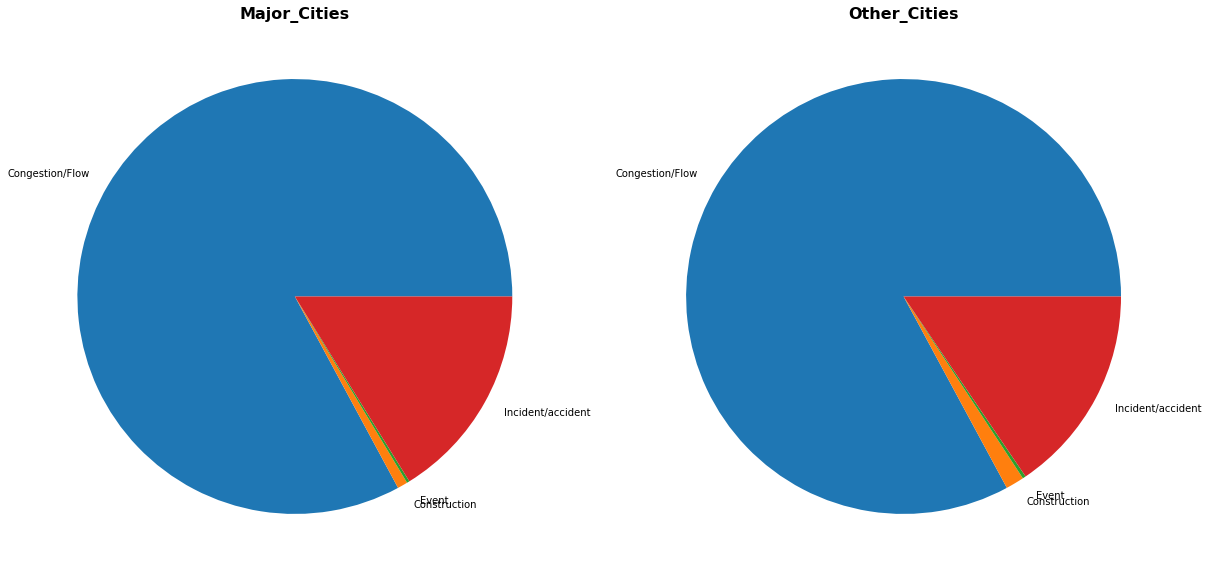

In [33]:
fg, axes = plt.subplots(1, 2, figsize=(20, 10))
type_distribution(major_cities,axes[0],'Major_Cities')
type_distribution(other_cities,axes[1],'Other_Cities')

Weekdays and weekends:

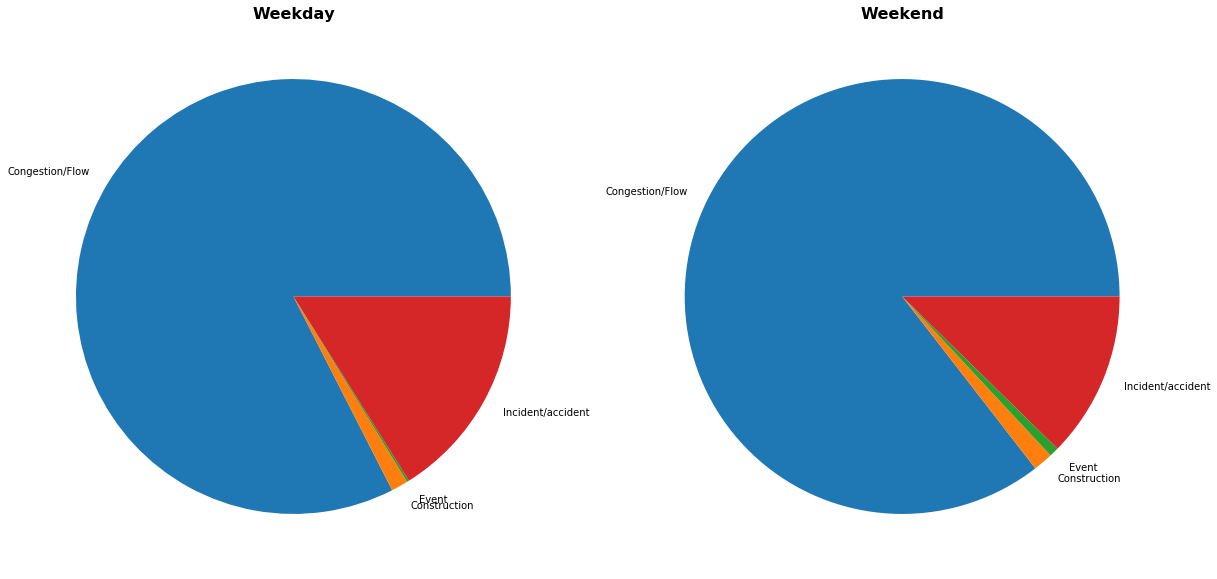

In [34]:
fg, axes = plt.subplots(1, 2, figsize=(20, 10))
type_distribution(weekday,axes[0],'Weekday')
type_distribution(weekend,axes[1],'Weekend')